# ***Desafío 2: Regresión lineal, Validación y Regularización***

**Grupo 5**

Integrantes:
*   Harry Lechtleiter
*   Tomás Martinez Bidal
*   Diana Garcés
*   Nicole Schein

## *Importamos los datos*

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn import linear_model
from sklearn import metrics

from statsmodels.tools import eval_measures

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
sns.set_context(context='poster')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data = pd.read_csv('/content/drive/MyDrive/properatti_fin_tp1.csv',index_col=0,).drop(labels=['description','title','place_name','description_minus', 'title_minus','suma_amenities'],axis=1)

In [8]:
data.reset_index(drop=True,inplace=True)

In [9]:
data.head(3)

,property_type,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,parent_lvl_1,parent_lvl_2,parent_lvl_3,parent_lvl_4,balcon,gimnasio,pileta,asador,cochera,lavanderia,lavadero,apto_prof,baulera,calefaccion,solarium,seguridad,price_per_total_m2,price_per_covered_m2
0,PH,62000.0,55.0,40.0,Sin especificar,Capital Federal,Mataderos,Sin especificar,Sin especificar,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1127.272727,1550.000000
1,apartment,72000.0,55.0,55.0,Sin especificar,Capital Federal,Mataderos,Sin especificar,Sin especificar,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1309.090909,1309.090909
2,apartment,64000.0,35.0,35.0,Sin especificar,Buenos Aires Costa Atlántica,Mar del Plata,Centro,Sin especificar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1828.571429,1828.571429


In [10]:
data.columns

Index(['property_type', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'rooms', 'parent_lvl_1', 'parent_lvl_2',
       'parent_lvl_3', 'parent_lvl_4', 'balcon', 'gimnasio', 'pileta',
       'asador', 'cochera', 'lavanderia', 'lavadero', 'apto_prof', 'baulera',
       'calefaccion', 'solarium', 'seguridad', 'price_per_total_m2',
       'price_per_covered_m2'],
      dtype='object')

## *Hacemos las variables dummies*

Dividimos las distintas columnas en tres listas ya que cada una va a tener un tratamiento distinto para llegar al formato que precisamos para aplicar los diferentes modelos, ya sea generar dummies con 'drop first', generar dummies eliminando 'Sin especificar' o pasando las columnas a intiger.

In [11]:
columnas_a_dummies = ['property_type', 'rooms']
columnas_a_int = ['balcon', 'gimnasio', 'pileta', 'asador', 'cochera', 'lavanderia', 'lavadero', 'apto_prof', 'baulera', 'calefaccion', 'solarium', 'seguridad']
columnas_parent = ['parent_lvl_1', 'parent_lvl_2', 'parent_lvl_3', 'parent_lvl_4']

In [12]:
data.loc[:,columnas_a_int] = data.loc[:,columnas_a_int].astype('int')

In [13]:
data.dtypes

property_type             object
price_aprox_usd          float64
surface_total_in_m2      float64
surface_covered_in_m2    float64
rooms                     object
parent_lvl_1              object
parent_lvl_2              object
parent_lvl_3              object
parent_lvl_4              object
balcon                     int64
gimnasio                   int64
pileta                     int64
asador                     int64
cochera                    int64
lavanderia                 int64
lavadero                   int64
apto_prof                  int64
baulera                    int64
calefaccion                int64
solarium                   int64
seguridad                  int64
price_per_total_m2       float64
price_per_covered_m2     float64
dtype: object

Generamos un diccionario vacío para guardar cada modelo de OneHotEncoder utilizado.

In [14]:
dic = {}

In [15]:
data_dummies = pd.DataFrame(index=data.index)

In [16]:
def dummy_encoder(dic,data,columns,data_dummies,null='Sin especificar'):
  for i in columns:
    if null in data[i].unique():
      dic[i] = OneHotEncoder(drop=[null],dtype='int')

      dummy_onehot = dic[i].fit_transform(data[[i]])

      categorias = np.delete( dic[i].categories_[0],np.where( dic[i].categories_[0]=='Sin especificar'))

      data_dummies = data_dummies.join(pd.DataFrame(data=dummy_onehot.toarray(),columns=[f'{i}-{x}' for x in categorias]))

    else:
      dic[i] = OneHotEncoder(drop='first',dtype='int')

      dummy_onehot = dic[i].fit_transform(data[[i]])

      data_dummies = data_dummies.join(pd.DataFrame(data=dummy_onehot.toarray(),columns=[f'{i}-{x}' for x in  dic[i].categories_[0][1:]]))

  return data_dummies

In [17]:
data_dummies = dummy_encoder(dic=dic, data=data, columns=columnas_a_dummies, data_dummies=data_dummies)
data_dummies.head(2)

,property_type-apartment,property_type-house,property_type-store,rooms-1.0,rooms-10.0,rooms-11.0,rooms-12.0,rooms-13.0,rooms-14.0,rooms-15.0,rooms-16.0,rooms-17.0,rooms-18.0,rooms-19.0,rooms-2.0,rooms-20.0,rooms-21.0,rooms-22.0,rooms-23.0,rooms-25.0,rooms-27.0,rooms-3.0,rooms-30.0,rooms-32.0,rooms-4.0,rooms-5.0,rooms-6.0,rooms-7.0,rooms-8.0,rooms-9.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
data_dummies = dummy_encoder(dic=dic, data=data, columns=columnas_parent, data_dummies=data_dummies)
data_dummies.head(2)

,property_type-apartment,property_type-house,property_type-store,rooms-1.0,rooms-10.0,rooms-11.0,rooms-12.0,rooms-13.0,rooms-14.0,rooms-15.0,rooms-16.0,rooms-17.0,rooms-18.0,rooms-19.0,rooms-2.0,rooms-20.0,rooms-21.0,rooms-22.0,rooms-23.0,rooms-25.0,rooms-27.0,rooms-3.0,rooms-30.0,rooms-32.0,rooms-4.0,rooms-5.0,rooms-6.0,rooms-7.0,rooms-8.0,rooms-9.0,parent_lvl_1-Bs.As. G.B.A. Zona Oeste,parent_lvl_1-Bs.As. G.B.A. Zona Sur,parent_lvl_1-Buenos Aires Costa Atlántica,parent_lvl_1-Buenos Aires Interior,parent_lvl_1-Capital Federal,parent_lvl_1-Catamarca,parent_lvl_1-Chaco,parent_lvl_1-Chubut,parent_lvl_1-Corrientes,parent_lvl_1-Córdoba,...,parent_lvl_3-Villa Luzuriaga,parent_lvl_3-Villa Lynch,parent_lvl_3-Villa Madero,parent_lvl_3-Villa Maipu,parent_lvl_3-Villa Martelli,parent_lvl_3-Villa Monteagudo,parent_lvl_3-Villa Pacheco,parent_lvl_3-Villa Primera,parent_lvl_3-Villa Raffo,parent_lvl_3-Villa Rosa,parent_lvl_3-Villa Sarmiento,parent_lvl_3-Villa Tesei,parent_lvl_3-Villa Udaondo,parent_lvl_3-Villa Vatteone,parent_lvl_3-Villa de Mayo,parent_lvl_3-Village Golf & Tennis Country Club,parent_lvl_3-Villars,parent_lvl_3-Virasoro Village,parent_lvl_3-Virrey del Pino,parent_lvl_3-Virreyes,parent_lvl_3-Wilde,parent_lvl_3-William Morris,parent_lvl_3-Zelaya,parent_lvl_3-Zárate,parent_lvl_3-coordenadas 34.255511,parent_lvl_4-Barrio Barrancas del Lago,parent_lvl_4-Barrio Cabos del Lago,parent_lvl_4-Barrio El Golf,parent_lvl_4-Barrio La Alameda,parent_lvl_4-Barrio La Isla,parent_lvl_4-Barrio Las Glorietas,parent_lvl_4-Barrio Los Alisos,parent_lvl_4-Barrio Los Castores,parent_lvl_4-Barrio Los Lagos,parent_lvl_4-Barrio Los Sauces,parent_lvl_4-Barrio Los Tilos,parent_lvl_4-BarrioPortezuelo,parent_lvl_4-Enyoi,parent_lvl_4-Islas del Canal,parent_lvl_4-QBay Yacht
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Decidimos eliminar las columnas que tenían menos de 100 observaciones para evitar problemas de sobreajuste de esos pequeños grupos.

In [19]:
min_filas = 100

print('Dimensiones antes de eliminar columnas: ', data_dummies.shape)

drop_labels = data_dummies.columns[data_dummies.sum() < min_filas]

data_dummies.drop(columns=drop_labels, inplace=True)

print('Dimensiones después de eliminar columnas: ', data_dummies.shape)

Dimensiones antes de eliminar columnas:  (64328, 958)
Dimensiones después de eliminar columnas:  (64328, 164)


# *Normalizamos*

In [20]:
numericals = ['surface_total_in_m2', 'surface_covered_in_m2']

X = data[numericals]

scaler = StandardScaler(with_mean=False)
scaler.fit(X)

std_numerical_data = scaler.transform(X)
std_df = pd.DataFrame(std_numerical_data, columns=[i + '_std' for i in numericals])
std_df.head(2)

,surface_total_in_m2_std,surface_covered_in_m2_std
0,0.462052,0.478449
1,0.462052,0.657868


# *X, y, Train, test split*

Concatenamos los dataframes que fuimos generando con las listas de columnas que resultan siendo los features que utilizaremos en el modelo.

In [21]:
X = pd.concat([std_df, data.loc[:,columnas_a_int],data_dummies], axis = 1)
X.head(2)

,surface_total_in_m2_std,surface_covered_in_m2_std,balcon,gimnasio,pileta,asador,cochera,lavanderia,lavadero,apto_prof,baulera,calefaccion,solarium,seguridad,property_type-apartment,property_type-house,property_type-store,rooms-1.0,rooms-2.0,rooms-3.0,rooms-4.0,rooms-5.0,rooms-6.0,rooms-7.0,rooms-8.0,parent_lvl_1-Bs.As. G.B.A. Zona Oeste,parent_lvl_1-Bs.As. G.B.A. Zona Sur,parent_lvl_1-Buenos Aires Costa Atlántica,parent_lvl_1-Buenos Aires Interior,parent_lvl_1-Capital Federal,parent_lvl_1-Chubut,parent_lvl_1-Corrientes,parent_lvl_1-Córdoba,parent_lvl_1-Mendoza,parent_lvl_1-Misiones,parent_lvl_1-Neuquén,parent_lvl_1-Río Negro,parent_lvl_1-San Luis,parent_lvl_1-Santa Fe,parent_lvl_1-Tucumán,...,parent_lvl_3-Jose Marmol,parent_lvl_3-La Lucila,parent_lvl_3-La Plata,parent_lvl_3-Lanús,parent_lvl_3-Lanús Oeste,parent_lvl_3-Lomas de Zamora,parent_lvl_3-Los Pingüinos Country Club,parent_lvl_3-Luján,parent_lvl_3-Manuel B Gonnet,parent_lvl_3-Martínez,parent_lvl_3-Monte Grande,parent_lvl_3-Morón,parent_lvl_3-Munro,parent_lvl_3-Muñiz,parent_lvl_3-Nordelta,parent_lvl_3-Olivos,parent_lvl_3-Palermo Hollywood,parent_lvl_3-Palermo Soho,parent_lvl_3-Pilar,parent_lvl_3-Quilmes,parent_lvl_3-Ramos Mejía,parent_lvl_3-Remedios de Escalada,parent_lvl_3-Rincón de Milberg,parent_lvl_3-San Andres,parent_lvl_3-San Carlos de Bariloche,parent_lvl_3-San Fernando,parent_lvl_3-San Isidro,parent_lvl_3-San Justo,parent_lvl_3-San Martín,parent_lvl_3-San Miguel,parent_lvl_3-Temperley,parent_lvl_3-Tigre,parent_lvl_3-Valentín Alsina,parent_lvl_3-Vicente López,parent_lvl_3-Victoria,parent_lvl_3-Villa Adelina,parent_lvl_3-Villa Ballester,parent_lvl_3-Villa Luzuriaga,parent_lvl_3-Wilde,parent_lvl_4-Barrio Los Alisos
0,0.462052,0.478449,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.462052,0.657868,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
X = sm.add_constant(X)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
y = data.price_per_total_m2

In [24]:
y

0        1127.272727
1        1309.090909
2        1828.571429
3        1226.415094
4        3066.666667
            ...     
64323     766.614338
64324    1625.348077
64325    1383.333333
64326    2858.695652
64327    1675.324675
Name: price_per_total_m2, Length: 64328, dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2,shuffle=True)

Notamos que según el random state que utilizamos llegamos a tener distintos resultados, principalmente debido a algunas propiedades como las de Bariloche que cuentan con columnas de parent_lvl identicos. Buscamos las columnas en X_train.

In [26]:
twin_columns = []
for i in range(X_train.shape[1]):
  for j in range(i+1, X_train.shape[1]):
    if (X_train.loc[:,X_train.columns[i]] == X_train.loc[:,X_train.columns[j]]).all():
      twin_columns.append(sorted([X_train.columns[i],X_train.columns[j]])[1])

print(twin_columns)

[]


In [27]:
similar_columns = []
similar_to_drop= []
for i in range(X_train.shape[1]):
  for j in range(i+1, X_train.shape[1]):
    if (X_train.iloc[:,i].dtype == 'int64') & (X_train.iloc[:,j].dtype == 'int64'):
      if X_train.loc[X_train.loc[:,X_train.columns[i]]==1,X_train.columns[j]].mean()>0.95:
        similar_columns.append((X_train.columns[i],X_train.columns[j]))
        similar_to_drop.append(X_train.columns[j])
similar_columns

[('lavanderia', 'property_type-apartment'),
 ('apto_prof', 'property_type-apartment'),
 ('parent_lvl_2-San Carlos de Bariloche',
  'parent_lvl_3-San Carlos de Bariloche')]

In [28]:
X_train.drop(labels=similar_to_drop[2:],axis=1,inplace=True)
X_test.drop(labels=similar_to_drop[2:],axis=1,inplace=True)

## *Linealización*

Verificamos con regplot el orden de los polinomios que ajustan bien a los datos.

(-100.0, 6000.0)

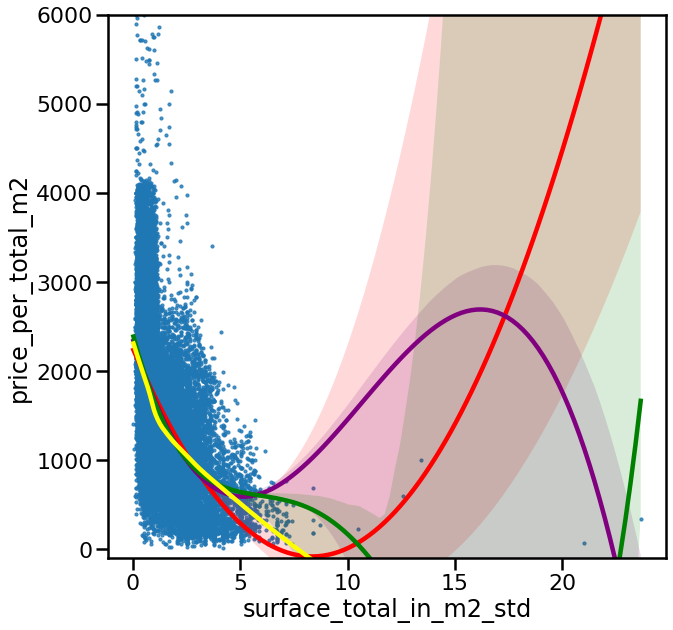

In [29]:
plt.figure(figsize=(10,10))
sns.regplot(x=X_train['surface_total_in_m2_std'],y=y_train,order=2,scatter_kws={"s": 10},line_kws={"color": "red"})
sns.regplot(x=X_train['surface_total_in_m2_std'],y=y_train,order=3,scatter_kws={"s": 0},line_kws={"color": "purple"})
sns.regplot(x=X_train['surface_total_in_m2_std'],y=y_train,order=4,scatter_kws={"s": 0},line_kws={"color": "green"})
sns.regplot(x=X_train['surface_total_in_m2_std'],y=y_train,lowess=True,scatter_kws={"s": 0},line_kws={"color": "yellow"})
#sns.regplot(x=X_train['surface_covered_in_m2_std'],y=y_train,order=10,scatter_kws={"s": 0},line_kws={"color": "yellow"})
#plt.xlim(0,21)
plt.ylim(-100,6000)

Verificando las regresiones con polinomios de orden 2, 3, 4 y 10 las curvas son similares para los ordenes 2, 3 y 4. Ya que el orden 4 en verde no solo ajusta mejor por ser de mayor orden sino que tambien oscila menos parece ser el orden correcto para implementar en el modelo.

Por último terminamos aplicando la función exponencial a los datos por dos motivos. Las regresiones parecen tener el comportamiento decreciente de una exponencial y al mismo tiempo nos evitamos tener valores muy altos de precio estimado cuando las propiedades son de gran superficie. Ya que el polinomio no ajusta bien para los últimos valores de gran superficie la función exponencial decreciente hace un mejor trabajo ya que cuenta con una asíntota.

(0.0, 4000.0)

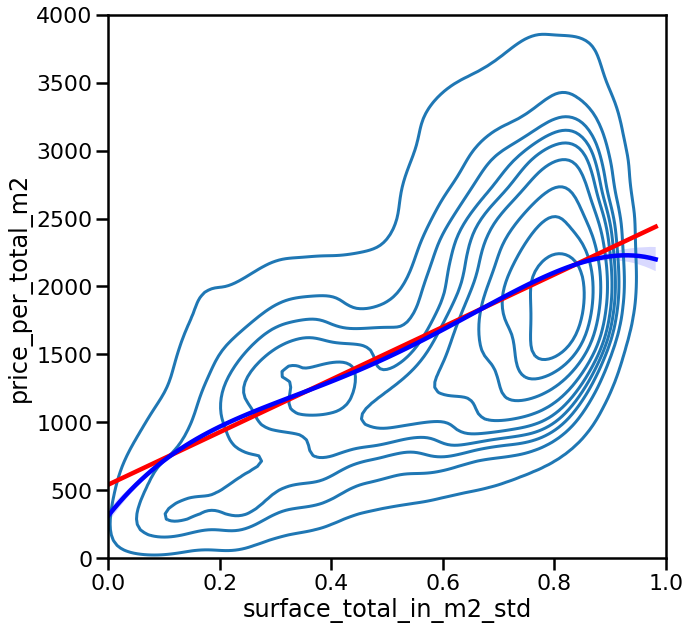

In [30]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=np.power(1.75,-X_train['surface_total_in_m2_std']),y=y_train)
sns.regplot(x=np.power(1.75,-X_train['surface_total_in_m2_std']),y=y_train,order=1,scatter_kws={"s": 0},line_kws={"color": "red"})
sns.regplot(x=np.power(1.75,-X_train['surface_total_in_m2_std']),y=y_train,order=4,scatter_kws={"s": 0},line_kws={"color": "blue"})#1.75
#sns.regplot(x=np.exp(X_train['surface_total_in_m2_std']),y=y_train,order=3,scatter_kws={"s": 0},line_kws={"color": "green"})
plt.xlim(0,1)
plt.ylim(0,4000)

In [31]:
X_train['surface_covered_in_m2_std'] = np.power(1.75,-X_train['surface_covered_in_m2_std'])
X_train['surface_total_in_m2_std'] = np.power(1.75,-X_train['surface_total_in_m2_std'])
X_test['surface_covered_in_m2_std'] = np.power(1.75,-X_test['surface_covered_in_m2_std'])
X_test['surface_total_in_m2_std'] = np.power(1.75,-X_test['surface_total_in_m2_std'])

In [32]:
# def a_polinomio(df,N=4):
#   for columna in ['surface_total_in_m2_std','surface_covered_in_m2_std']:
#     N=N
#     df = df.join(pd.DataFrame(data = np.vander(df[columna].values,N=N+1), columns=[f'{columna}^{i}'for i in range(N,-1,-1)], index = df.index).iloc[:,:N-1])
#   return df

# X_train = a_polinomio(X_train,4)
# X_test = a_polinomio(X_test,4)

In [33]:
X_train.head(2)

,const,surface_total_in_m2_std,surface_covered_in_m2_std,balcon,gimnasio,pileta,asador,cochera,lavanderia,lavadero,apto_prof,baulera,calefaccion,solarium,seguridad,property_type-apartment,property_type-house,property_type-store,rooms-1.0,rooms-2.0,rooms-3.0,rooms-4.0,rooms-5.0,rooms-6.0,rooms-7.0,rooms-8.0,parent_lvl_1-Bs.As. G.B.A. Zona Oeste,parent_lvl_1-Bs.As. G.B.A. Zona Sur,parent_lvl_1-Buenos Aires Costa Atlántica,parent_lvl_1-Buenos Aires Interior,parent_lvl_1-Capital Federal,parent_lvl_1-Chubut,parent_lvl_1-Corrientes,parent_lvl_1-Córdoba,parent_lvl_1-Mendoza,parent_lvl_1-Misiones,parent_lvl_1-Neuquén,parent_lvl_1-Río Negro,parent_lvl_1-San Luis,parent_lvl_1-Santa Fe,...,parent_lvl_3-Ituzaingó,parent_lvl_3-Jose Marmol,parent_lvl_3-La Lucila,parent_lvl_3-La Plata,parent_lvl_3-Lanús,parent_lvl_3-Lanús Oeste,parent_lvl_3-Lomas de Zamora,parent_lvl_3-Los Pingüinos Country Club,parent_lvl_3-Luján,parent_lvl_3-Manuel B Gonnet,parent_lvl_3-Martínez,parent_lvl_3-Monte Grande,parent_lvl_3-Morón,parent_lvl_3-Munro,parent_lvl_3-Muñiz,parent_lvl_3-Nordelta,parent_lvl_3-Olivos,parent_lvl_3-Palermo Hollywood,parent_lvl_3-Palermo Soho,parent_lvl_3-Pilar,parent_lvl_3-Quilmes,parent_lvl_3-Ramos Mejía,parent_lvl_3-Remedios de Escalada,parent_lvl_3-Rincón de Milberg,parent_lvl_3-San Andres,parent_lvl_3-San Fernando,parent_lvl_3-San Isidro,parent_lvl_3-San Justo,parent_lvl_3-San Martín,parent_lvl_3-San Miguel,parent_lvl_3-Temperley,parent_lvl_3-Tigre,parent_lvl_3-Valentín Alsina,parent_lvl_3-Vicente López,parent_lvl_3-Victoria,parent_lvl_3-Villa Adelina,parent_lvl_3-Villa Ballester,parent_lvl_3-Villa Luzuriaga,parent_lvl_3-Wilde,parent_lvl_4-Barrio Los Alisos
28006,1.0,0.864382,0.812610,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51085,1.0,0.719578,0.625904,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


En un principio verificamos multicolinealidad entre features con el VIF, ya que la mayoría de nuestras variables son dummies (teniendo en cuenta que pueden tener un valor alto de VIF sin implicar multicolinealidad lo cual resulta en un filtro no claro). Al tener tantas columnas, el cálculo del VIF tomaba mucho tiempo y por eso decidimos finalmente no inlcuirlo. 

In [34]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor

In [35]:
# highest_vif = 6
# drop = []
# while highest_vif > 5:
#   series_vif = pd.Series([variance_inflation_factor(X_train.drop(labels=drop,axis=1).values, i) for i in range(X_train.drop(labels=drop,axis=1).shape[1])], index=X_train.drop(labels=drop,axis=1).columns)
#   highest_vif = series_vif.sort_values(ascending=False).iloc[1]
#   drop.append(series_vif.sort_values(ascending=False).index[1])
#   print(drop)
#   print(series_vif.sort_values(ascending=False).head(10))

In [36]:
# drop = ['parent_lvl_2-San Carlos de Bariloche', 'parent_lvl_1-Bs.As. G.B.A. Zona Sur', 'parent_lvl_1-Bs.As. G.B.A. Zona Oeste', 'parent_lvl_1-Capital Federal', 'parent_lvl_1-Buenos Aires Costa Atlántica', 'parent_lvl_2-Lanús', 'parent_lvl_1-Santa Fe', 'parent_lvl_2-Vicente López', 'parent_lvl_1-Misiones', 'parent_lvl_2-Lomas de Zamora', 'property_type-house', 'parent_lvl_2-Almirante Brown', 'parent_lvl_2-San Isidro', 'parent_lvl_2-La Matanza']

In [37]:
# series_vif = pd.Series([variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])], index=X_train.columns)

In [38]:
# series_vif.sort_values(ascending=False).head(35)

# *Prueba de Modelos*

## *Lineal Regression + CV (SKlearn)*

In [39]:
lm = linear_model.LinearRegression()

cv = KFold(10, shuffle=True)

scores = cross_val_score(lm, X_train, y_train, cv=cv, scoring='r2')

print(f'Cross validation score: {scores.mean()}')


model_1 = lm.fit(X_train, y_train)

print('Score model_1 Train:', model_1.score(X_train,y_train))

print('Score model_1 test:', model_1.score(X_test,y_test))# linea que "nunca" se uso

Cross validation score: 0.6962087378671419
Score model_1 Train: 0.698587882681708
Score model_1 test: 0.7048940209634258


In [40]:
 y_pred = model_1.predict(X_train)
 residuo = np.absolute(pd.Series(data = y_pred,index=y_train.index) - y_train)
 residuo.sort_values(ascending=False).head(10)

18356    5303.116712
64019    4243.689242
61510    4181.604203
42060    4178.994611
34532    4053.839591
61539    3914.935451
51235    3899.628921
11094    3890.526638
26685    3848.460654
19305    3762.227105
dtype: float64

In [41]:
pd.DataFrame(data = np.absolute(model_1.coef_), index=X_train.columns,columns=['Betas']).sort_values(by='Betas',ascending=False).head(10)
#Los betas son del orden de magnitud similar al precio por metro cuadrado por lo que consideramos no es necesario eliminar mas varaibles dummies

,Betas
surface_total_in_m2_std,2566.161191
surface_covered_in_m2_std,1396.102391
parent_lvl_2-San Isidro,814.784505
parent_lvl_2-Recoleta,750.530226
parent_lvl_2-Vicente López,704.226689
parent_lvl_2-Palermo,675.369078
parent_lvl_3-Boulogne Sur Mer,633.717585
parent_lvl_1-Capital Federal,626.263672
parent_lvl_2-Belgrano,610.459297
parent_lvl_2-Tigre,582.940579


Graficando los residuos vs los valores reales, la linea de regresion "local" en rojo es muy similar a la regresion lineal en amarillo de todos modos los puntos no parecen estar balanceados a ambos lados por lo que no se cumple la homocedasticidad.

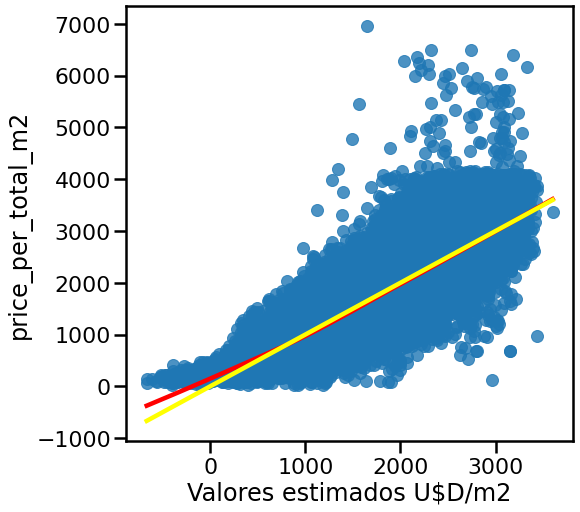

In [42]:
#demora 2 mins
plt.figure(figsize=(8,8))
sns.regplot(x=model_1.predict(X_train), y=y_train,lowess=True,line_kws={'color': 'red'})
plt.xlabel('Valores estimados U$D/m2')
plt.ylabel('Valores reales U$D/m2')
sns.regplot(x=model_1.predict(X_train), y=y_train,line_kws={'color': 'yellow'},scatter_kws={"s": 0})

Verificando el QQ plot para este primer modelo la distribucion de los residuos no es normal.

Text(0.5, 1.0, 'Q-Q plot')

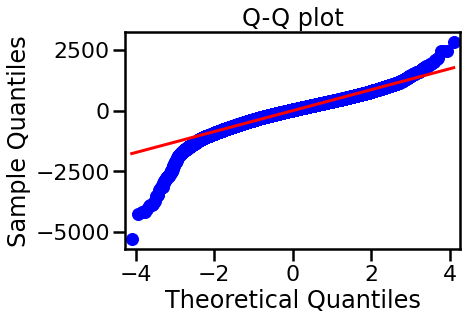

In [43]:
sm.ProbPlot(model_1.predict(X_train)-y_train).qqplot(line='s');
plt.title('Q-Q plot')

## *Lineal Regression  (StatsModels)*

Verificamos la regresión lineal también con OLS de statmodel para verificar el resumen que provee este modelo y también para identificar los coeficientes con pvalor de betas mayor a 0.5.

In [44]:
model = sm.OLS(y_train,X_train).fit()

In [45]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     price_per_total_m2   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     629.4
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:09:33   Log-Likelihood:            -3.6116e+05
No. Observations:               48246   AIC:                         7.227e+05
Df Residuals:                   48068   BIC:                         7.242e+05
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [46]:
columns_to_drop = []
for limite in [0.2,0.1,0.05,0.05,0.01]:
  model = sm.OLS(y_train,X_train.drop(columns=columns_to_drop)).fit()
  columns_to_drop.extend(model.pvalues[model.pvalues > limite].index)

In [47]:
columns_to_drop

['parent_lvl_1-Mendoza',
 'parent_lvl_1-Misiones',
 'parent_lvl_1-Río Negro',
 'parent_lvl_1-San Luis',
 'parent_lvl_2-Chacarita',
 'parent_lvl_2-La Plata',
 'parent_lvl_2-Lanús',
 'parent_lvl_2-Lomas de Zamora',
 'parent_lvl_2-Luján',
 'parent_lvl_2-Merlo',
 'parent_lvl_2-Moreno',
 'parent_lvl_2-Morón',
 'parent_lvl_2-Posadas',
 'parent_lvl_2-San Miguel',
 'parent_lvl_2-San Nicolás',
 'parent_lvl_2-Santa Fe',
 'parent_lvl_2-Tres de Febrero',
 'parent_lvl_2-Villa Carlos Paz',
 'parent_lvl_2-Villa Gesell',
 'parent_lvl_3-Acassuso',
 'parent_lvl_3-Belén de Escobar',
 'parent_lvl_3-Burzaco',
 'parent_lvl_3-Canning',
 'parent_lvl_3-El Palomar',
 'parent_lvl_3-Florida',
 'parent_lvl_3-Haras Santa Maria',
 'parent_lvl_3-Lanús',
 'parent_lvl_3-Lanús Oeste',
 'parent_lvl_3-Luján',
 'parent_lvl_3-Martínez',
 'parent_lvl_3-Morón',
 'parent_lvl_3-Muñiz',
 'parent_lvl_3-Palermo Soho',
 'parent_lvl_3-Quilmes',
 'parent_lvl_3-Remedios de Escalada',
 'parent_lvl_3-San Martín',
 'parent_lvl_4-Barrio L

Guardamos las columnas que tienen un bajo P-valor ya que si las eliminamos directamente generan que el modelo de lasso elija siempre el alpha mas bajo de los que se proponen

## *Lineal Regression + CV + Ridge (SKlearn)*

Probamos el modelo de Ridge y definiendo una función para graficar buscamos el valor óptimo de alpha.

In [48]:
def plot_best_alpha_2(model):
  sns.lineplot(y=model.cv_values_.transpose().mean(axis=1),x=model.alphas)
  print(f'El mejor alpha es: {model.alpha_}')
  print(f'Los alphas utilizados fueron :\n{model.alphas}')

El mejor alpha es: 2.08
Los alphas utilizados fueron :
[ 0.1   1.09  2.08  3.07  4.06  5.05  6.04  7.03  8.02  9.01 10.  ]


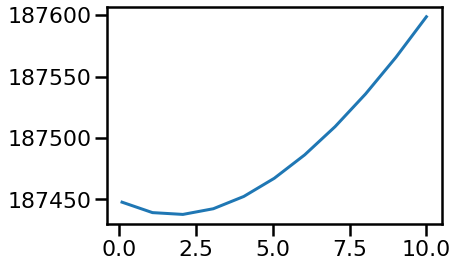

In [49]:
model_ridge = linear_model.RidgeCV(alphas=np.linspace(0.1,10,11),cv=None,store_cv_values=True).fit(X_train, y_train)
plot_best_alpha_2(model_ridge)

El mejor alpha es: 1.8
Los alphas utilizados fueron :
[1.   1.02 1.04 1.06 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26
 1.28 1.3  1.32 1.34 1.36 1.38 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54
 1.56 1.58 1.6  1.62 1.64 1.66 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82
 1.84 1.86 1.88 1.9  1.92 1.94 1.96 1.98 2.   2.02 2.04 2.06 2.08 2.1
 2.12 2.14 2.16 2.18 2.2  2.22 2.24 2.26 2.28 2.3  2.32 2.34 2.36 2.38
 2.4  2.42 2.44 2.46 2.48 2.5  2.52 2.54 2.56 2.58 2.6  2.62 2.64 2.66
 2.68 2.7  2.72 2.74 2.76 2.78 2.8  2.82 2.84 2.86 2.88 2.9  2.92 2.94
 2.96 2.98 3.  ]


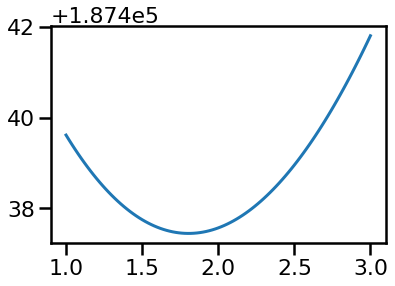

In [50]:
model_ridge = linear_model.RidgeCV(alphas=np.linspace(1,3,101),cv=None,store_cv_values=True).fit(X_train, y_train)
plot_best_alpha_2(model_ridge)

## *Lineal Regression + CV + Lasso*

Repetimos el procedimiento anterior pero con el modelo de Lasso.

In [51]:
def plot_best_alpha(model):
  sns.lineplot(y=model.mse_path_.mean(axis=1),x=model.alphas[::-1])
  print(f'El mejor alpha es: {model.alpha_}')
  print(f'Los alphas utilizados fueron :\n{model.alphas}')

El mejor alpha es: 0.1
Los alphas utilizados fueron :
[ 0.1    0.199  0.298  0.397  0.496  0.595  0.694  0.793  0.892  0.991
  1.09   1.189  1.288  1.387  1.486  1.585  1.684  1.783  1.882  1.981
  2.08   2.179  2.278  2.377  2.476  2.575  2.674  2.773  2.872  2.971
  3.07   3.169  3.268  3.367  3.466  3.565  3.664  3.763  3.862  3.961
  4.06   4.159  4.258  4.357  4.456  4.555  4.654  4.753  4.852  4.951
  5.05   5.149  5.248  5.347  5.446  5.545  5.644  5.743  5.842  5.941
  6.04   6.139  6.238  6.337  6.436  6.535  6.634  6.733  6.832  6.931
  7.03   7.129  7.228  7.327  7.426  7.525  7.624  7.723  7.822  7.921
  8.02   8.119  8.218  8.317  8.416  8.515  8.614  8.713  8.812  8.911
  9.01   9.109  9.208  9.307  9.406  9.505  9.604  9.703  9.802  9.901
 10.   ]


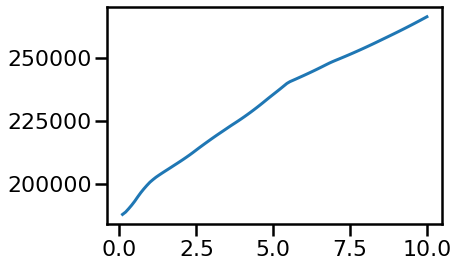

In [52]:
model_lasso = linear_model.LassoCV(alphas=np.linspace(0.1,10,101),cv=10).fit(X_train, y_train)
plot_best_alpha(model_lasso)

Encontramos el mejor valor de alpha en 0.224.

El mejor alpha es: 0.0224
Los alphas utilizados fueron :
[0.018  0.0184 0.0188 0.0192 0.0196 0.02   0.0204 0.0208 0.0212 0.0216
 0.022  0.0224 0.0228 0.0232 0.0236 0.024  0.0244 0.0248 0.0252 0.0256
 0.026 ]


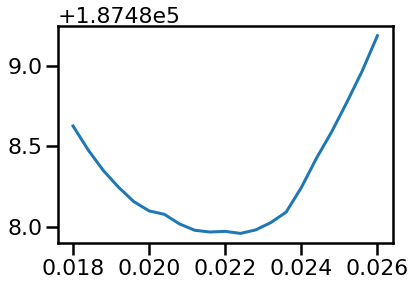

In [53]:
model_lasso = linear_model.LassoCV(alphas=np.linspace(0.018,.026,21),cv=10).fit(X_train, y_train)
plot_best_alpha(model_lasso)

Verificando valores aún menores de alpha la función de costo vuelve a crecer.

El mejor alpha es: 0.022000000000000002
Los alphas utilizados fueron :
[0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012
 0.013 0.014 0.015 0.016 0.017 0.018 0.019 0.02  0.021 0.022 0.023]


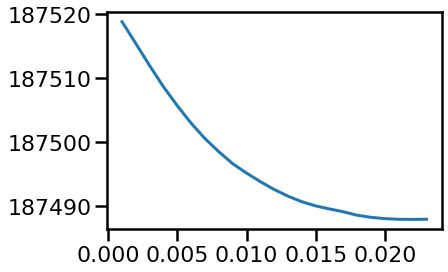

In [54]:
model_lasso = linear_model.LassoCV(alphas=np.linspace(0.001,.023,23),cv=10).fit(X_train, y_train)
plot_best_alpha(model_lasso)

## *Lineal Regression + CV + ElasticNet*

Por último probamos el modelo elastic-net siendo la combinacion de los dos modelos anteriores. Tambien buscamos el alpha optimo junto con el l1_ratio optimo.

In [55]:
def plot_best_alpha_2xpixi(model,annot=True,round=2,round2=3):
  plt.figure(figsize=(15,10))
  g = sns.heatmap(pd.DataFrame(data = model.mse_path_.mean(axis=2)-model.mse_path_.mean(), index = model.l1_ratio, columns = model.alphas_),cmap="rocket_r", annot=annot)
  print(f'El mejor alpha es: {model.alpha_}')
  print(f'Los alphas utilizados fueron :\n{model.alphas_}')
  print(f'El mejor l1_ratio es: {model.l1_ratio_}')
  print(f'Los l1_ratio utilizados fueron :\n{model.l1_ratio}')  
  xlabels = [x for x in model.alphas_.round(round2)]
  ylabels = model.l1_ratio.round(round)
  g.set_xticklabels(xlabels)
  g.set_yticklabels(ylabels)
  plt.xlabel('Alphas')
  plt.ylabel('L1_ratio')

In [56]:
elastic_net = linear_model.ElasticNetCV(alphas=np.linspace(0.1,1,10),l1_ratio=np.linspace(0.9,1,6),cv=5).fit(X_train, y_train)

El mejor alpha es: 0.02
Los alphas utilizados fueron :
[0.03  0.028 0.026 0.024 0.022 0.02  0.018 0.016 0.014 0.012 0.01  0.008
 0.006]
El mejor l1_ratio es: 1.0
Los l1_ratio utilizados fueron :
[0.995 0.996 0.997 0.998 0.999 1.   ]


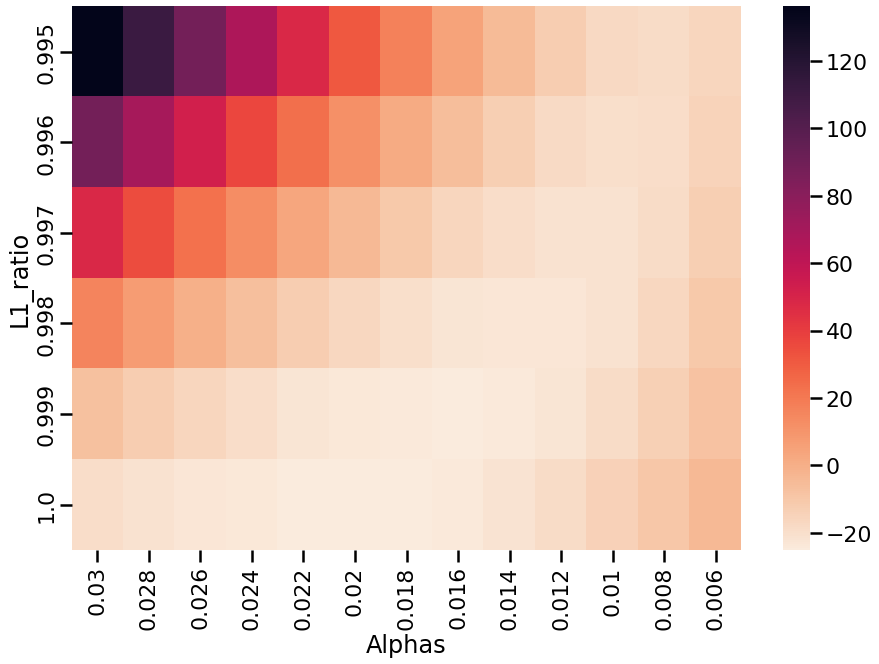

In [59]:
plot_best_alpha_2xpixi(elastic_net,annot=False,round=3)

El modelo elastic-net toma un valor óptimo de l1_ratio de 1 o muy similar, por lo que el modelo termina utilizando la función de costo de Lasso.

Con sentido el valor de alpha es practicamente el mismo que utiliza el modelo de Lasso.

El mejor alpha es: 0.02
Los alphas utilizados fueron :
[0.03  0.028 0.026 0.024 0.022 0.02  0.018 0.016 0.014 0.012 0.01  0.008
 0.006]
El mejor l1_ratio es: 1.0
Los l1_ratio utilizados fueron :
[0.995 0.996 0.997 0.998 0.999 1.   ]


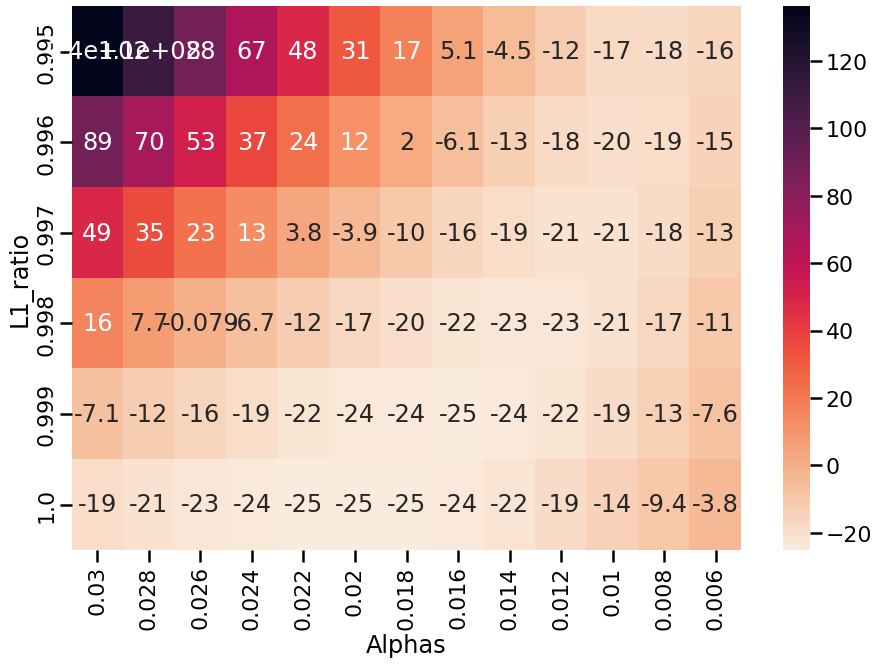

In [58]:
elastic_net = linear_model.ElasticNetCV(alphas=np.linspace(.006,.03,13),l1_ratio=np.linspace(0.995,1,6),cv=5).fit(X_train, y_train)
plot_best_alpha_2xpixi(elastic_net,round=3)

Nuevamente la grafica de los residuos muestra que no se hay homocedasticidad.

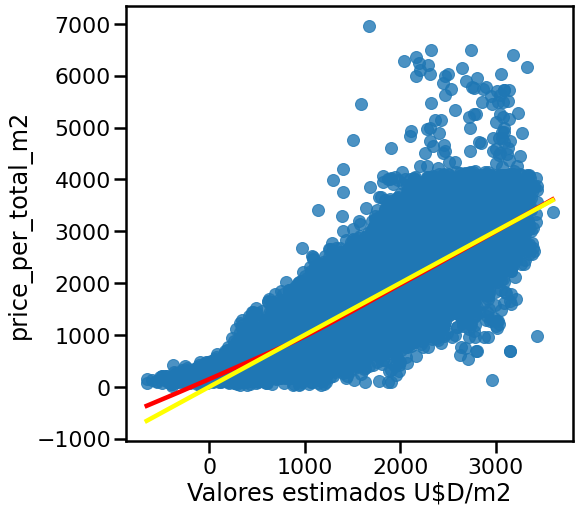

In [ ]:
plt.figure(figsize=(8,8))
sns.regplot(x=elastic_net.predict(X_train), y=y_train,lowess=True,line_kws={'color': 'red'})
plt.xlabel('Valores estimados U$D/m2')
plt.ylabel('Valores reales U$D/m2')
sns.regplot(x=elastic_net.predict(X_train), y=y_train,line_kws={'color': 'yellow'},scatter_kws={"s": 0})

Text(0.5, 1.0, 'Q-Q plot')

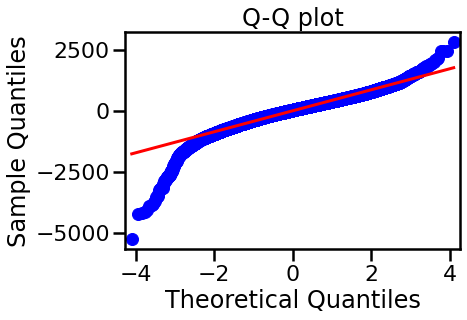

In [ ]:
sm.ProbPlot(elastic_net.predict(X_train)-y_train).qqplot(line='s');
plt.title('Q-Q plot')

Verificando el QQ plot los residuos no siguen una la distribución gaussiana.

Analizando este resultado junto con el kdeplot generado al momento de linealizar los datos se puede pensar que existen al menos dos subgrupos de datos con propiedades estadisticas distintas.

In [ ]:
models_list = {'Regresion lineal (SKlearn)':model_1, 'Modelo Ridge':model_ridge, 'Modelo Lasso':model_lasso, 'Elastic model':elastic_net}
for i in models_list.keys():
  models_list[i].fit(X_train,y_train)
  print(f'Modelo: {i}')
  print('Train score: ',models_list[i].score(X_train,y_train).round(4))
  print('Test score: ',models_list[i].score(X_test,y_test).round(4))
  print('\n')

Modelo: Regresion lineal (SKlearn)
Train score:  0.6986
Test score:  0.7049


Modelo: Modelo Ridge
Train score:  0.6986
Test score:  0.7048


Modelo: Modelo Lasso
Train score:  0.6985
Test score:  0.7048


Modelo: Elastic model
Train score:  0.6985
Test score:  0.7048




Si graficamos en un kde plot la variable de superficie con las transformaciones aplicadas vs el precio por m2 y separando los datos por property type vemos que al menos con ese criterio los grupos tienen comportamientos distintos que podrian ser una de laas causas de falta de normalidad en los residuos.

Una adicion interesante al modelo podria ser utilizar este division para generar modelos dintintos para gada grupo.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


(0.0, 1.0)

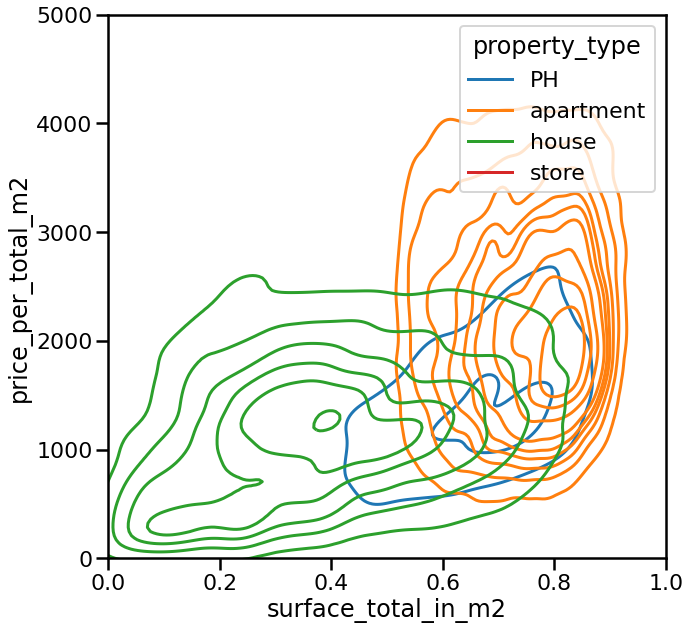

In [ ]:
plt.figure(figsize=(10,10))
sns.kdeplot(x=np.power(1.75,-data.surface_total_in_m2/119),y=data.price_per_total_m2,hue=data.property_type)
plt.ylim(0,5000)
plt.xlim(0,1)

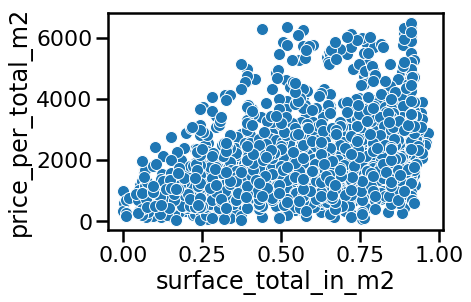

In [ ]:
sns.scatterplot(x=np.power(1.75,-data[data.property_type == 'store'].surface_total_in_m2/119),y=data.price_per_total_m2)